In [1]:
from oi_fit import OI
from fit_routine import WLAX, Lines, lines, oi_doublet, single, c, z
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hdul1 = fits.open("../cube_rebin.fits")
head = hdul1[0].header
cubehdu = hdul1[0]
cubehead = cubehdu.header
cube = cubehdu.data


hdu = fits.open("../varc_rebin.fits")
varc = hdu[0].data

hdul2 = fits.open("../basespec_smoothed.fits")
basespec = hdul2[0].data

oi = OI('OI', lines['OI'][0], lines['OI'][1], lines['OI'][2], cube, varc, basespec)
oi.lranges

(6343.240679874535, 6450.036868428668)

(6364.436255400001, 6364.436255400001)

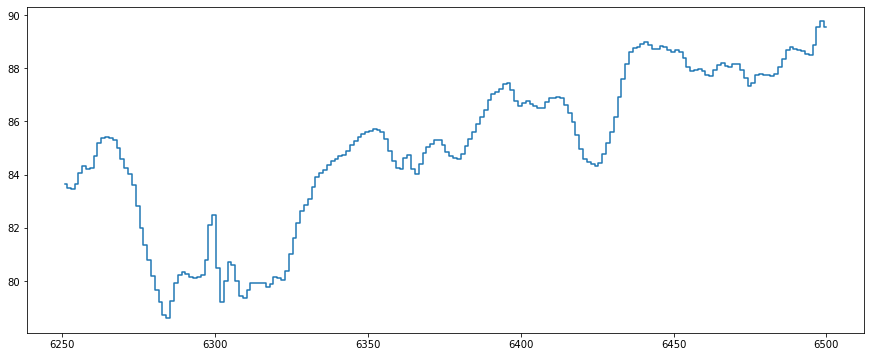

In [8]:
plt.figure(figsize=(15,6))
plt.step(oi.wlax, oi.basespec, where='mid')
oi.obs

In [ ]:

quickrej = 0
snrrej = 0
runerr = 0

obs_0 = oi.obs[0]
mask = (oi.lranges[0] < oi.wlax) & (oi.wlax < oi.lranges[1])
l_wlax = oi.wlax[mask]
l_lranges = oi.lranges

stime = time.time()
for i in tqdm(range(oi.cube_x), smoothing=1):
    

    for j in range(oi.cube_y):
        
        fit_spec, err_spec = oi.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej +=1
            oi.rejcube[0,i,j] = 1
            continue

        try:
            
            popt, pcov = curve_fit(oi_doublet, l_wlax, fit_spec[mask], p0=[50, 150, obs_0, 2.3], 
                                   bounds=([0, 0 ,l_lranges[0],0], [2e4, 2e4, l_lranges[1], 20]), 
                                   absolute_sigma=True, sigma=err_spec[mask])

            uncertainty = np.sqrt(np.np.diagnoal(pcov))
            snr1 = popt[0] / uncertainty[0]
            snr2 = popt[1] / uncertainty[1]
            #snr = popt[0]/uncertainty[0]
            
            if  snr1 > 3. and snr2 > 3.:
            #if snr > 3.:
                oi.fitcube[:4,i,j] = popt[:]
                oi.fitcube[4,i,j] = snr1
                oi.fitcube[5,i,j] = snr2
                oi.fiterrcube[:,i,j] = uncertainty
            else:
                oi.fitcube[:4,i,j] = np.nan
                oi.fitcube[4,i,j] = snr1
                oi.fitcube[5,i,j] = snr2
  
                
                oi.rejcube[1,i,j] = 1
                snrrej += 1
                
        except (RuntimeError, ValueError):
            oi.set_to_nan(i, j)
            oi.rejcube[2,i,j] = 1
            runerr +=1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)

from astropy.wcs import WCS

newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(oi.fitcube[0], header=newhead)
newoihdus = [fits.ImageHDU(oi.fitcube[i]) for i in range(1,6)]
oierrhdus = [fits.ImageHDU(oi.fiterrcube[i]) for i in range(4)]
hdul = fits.HDUList([prihdu] + newoihdus + oierrhdus)
hdul.writeto('../OI_fit/oi_fit_test.fits', overwrite = True)

rejhdus = fits.PrimaryHDU(oi.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(oi.rejcube[i]) for i in range(1,3)]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../OI_fit/oi_rej_test.fits', overwrite = True)

detectedimg = np.nan_to_num(oi.fitcube[0])
snrrejimg = np.nan_to_num(oi.rejcube[1])
evalimg = detectedimg + snrrejimg

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../OI_fit/oi_eval_test.fits', overwrite = True)

flux0hdus = [prihdu]
flux1hdus = [fits.ImageHDU(oi.fitcube[1])]
velhdus = [fits.ImageHDU(c*(oi.fitcube[2]/oi.rest[0]-1-z))]
vdisphdus = [fits.ImageHDU(c*(oi.fitcube[3]/oi.rest[0]))]
resulthdus =  fits.HDUList(flux0hdus+flux1hdus+velhdus+vdisphdus)
resulthdus.writeto('../OI_fit/oi_result_test.fits', overwrite=True)

In [6]:
#Fit OI6302 only
oi = OI('OI6300', lines['OI6300'][0], lines['OI6300'][1], lines['OI6300'][2], cube, varc, basespec)
quickrej = 0
snrrej = 0
runerr = 0

obs_0 = oi.obs[0]
mask = (oi.lranges[0] < oi.wlax) & (oi.wlax < oi.lranges[1])
l_wlax = oi.wlax[mask]
l_lranges = oi.lranges

stime = time.time()
for i in tqdm(range(oi.cube_x), smoothing=1):
    

    for j in range(oi.cube_y):
        
        fit_spec, err_spec = oi.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej +=1
            oi.rejcube[0,i,j] = 1
            continue

        try:
            
            popt, pcov = curve_fit(single, l_wlax, fit_spec[mask], p0=[150, obs_0, 2.3, 0], 
                                   bounds=([0 ,l_lranges[0],0, -50], [2e4, l_lranges[1], 20, 50]), 
                                   absolute_sigma=True, sigma=err_spec[mask])

            uncertainty = np.sqrt(np.diagonal(pcov))
            snr1 = popt[0] / uncertainty[0]
            #snr2 = popt[1] / uncertainty[1]
            #snr = popt[0]/uncertainty[0]
            
            #if  snr1 > 3. and snr2 > 3.:
            if snr1 > 3.:
                oi.fitcube[:4,i,j] = popt[:]
                oi.fitcube[4,i,j] = snr1
                #oi.fitcube[5,i,j] = snr2
                oi.fiterrcube[:,i,j] = uncertainty
            else:
                oi.fitcube[:4,i,j] = np.nan
                oi.fitcube[4,i,j] = snr1
                #oi.fitcube[5,i,j] = snr2
  
                
                oi.rejcube[1,i,j] = 1
                snrrej += 1
                
        except (RuntimeError, ValueError):
            oi.set_to_nan(i, j)
            oi.rejcube[2,i,j] = 1
            runerr +=1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)

from astropy.wcs import WCS

newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(oi.fitcube[0], header=newhead)
newoihdus = [fits.ImageHDU(oi.fitcube[i]) for i in range(1,oi.fitcube.shape[0])]
oierrhdus = [fits.ImageHDU(oi.fiterrcube[i]) for i in range(oi.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newoihdus + oierrhdus)
hdul.writeto('../OI_fit/oi_fit_single_cont.fits', overwrite = True)

rejhdus = fits.PrimaryHDU(oi.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(oi.rejcube[i]) for i in range(1,oi.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../OI_fit/oi_rej_single_cont.fits', overwrite = True)

detectedimg = np.nan_to_num(oi.fitcube[0])
snrrejimg = np.nan_to_num(oi.rejcube[1])
evalimg = detectedimg + snrrejimg

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../OI_fit/oi_eval_single_cont.fits', overwrite = True)

flux0hdus = [prihdu]
velhdus = [fits.ImageHDU(c*(oi.fitcube[1]/oi.rest[0]-1-z))]
vdisphdus = [fits.ImageHDU(c*(oi.fitcube[2]/oi.rest[0]))]
resulthdus =  fits.HDUList(flux0hdus+velhdus+vdisphdus)
resulthdus.writeto('../OI_fit/oi_result_single_cont.fits', overwrite=True)

  2%|▏         | 1/65 [00:00<00:43,  1.46it/s]/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_20342/1833043903.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  snr1 = popt[0] / uncertainty[0]
  6%|▌         | 4/65 [00:02<00:43,  1.40it/s]/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:173: RuntimeWarning: invalid value encountered in sqrt
  if sum(fit_spec)/np.sqrt(sum(self.varspec)) < self.quickrej_threshold:
/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:177: RuntimeWarning: invalid value encountered in sqrt
  return fit_spec, deepcopy(np.sqrt(self.varspec))
/Users/gordonwongyl/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
100%|██████████| 65/65 [00:58<00:00,  1.12it/s]

3192
2005
15
58.124695777893066


In [3]:
oi = OI('OI6300', lines['OI6300'][0], lines['OI6300'][1], lines['OI6300'][2], cube, varc, basespec)
oi.load_fitcubes("../OI_fit/oi_fit_single_cont.fits")

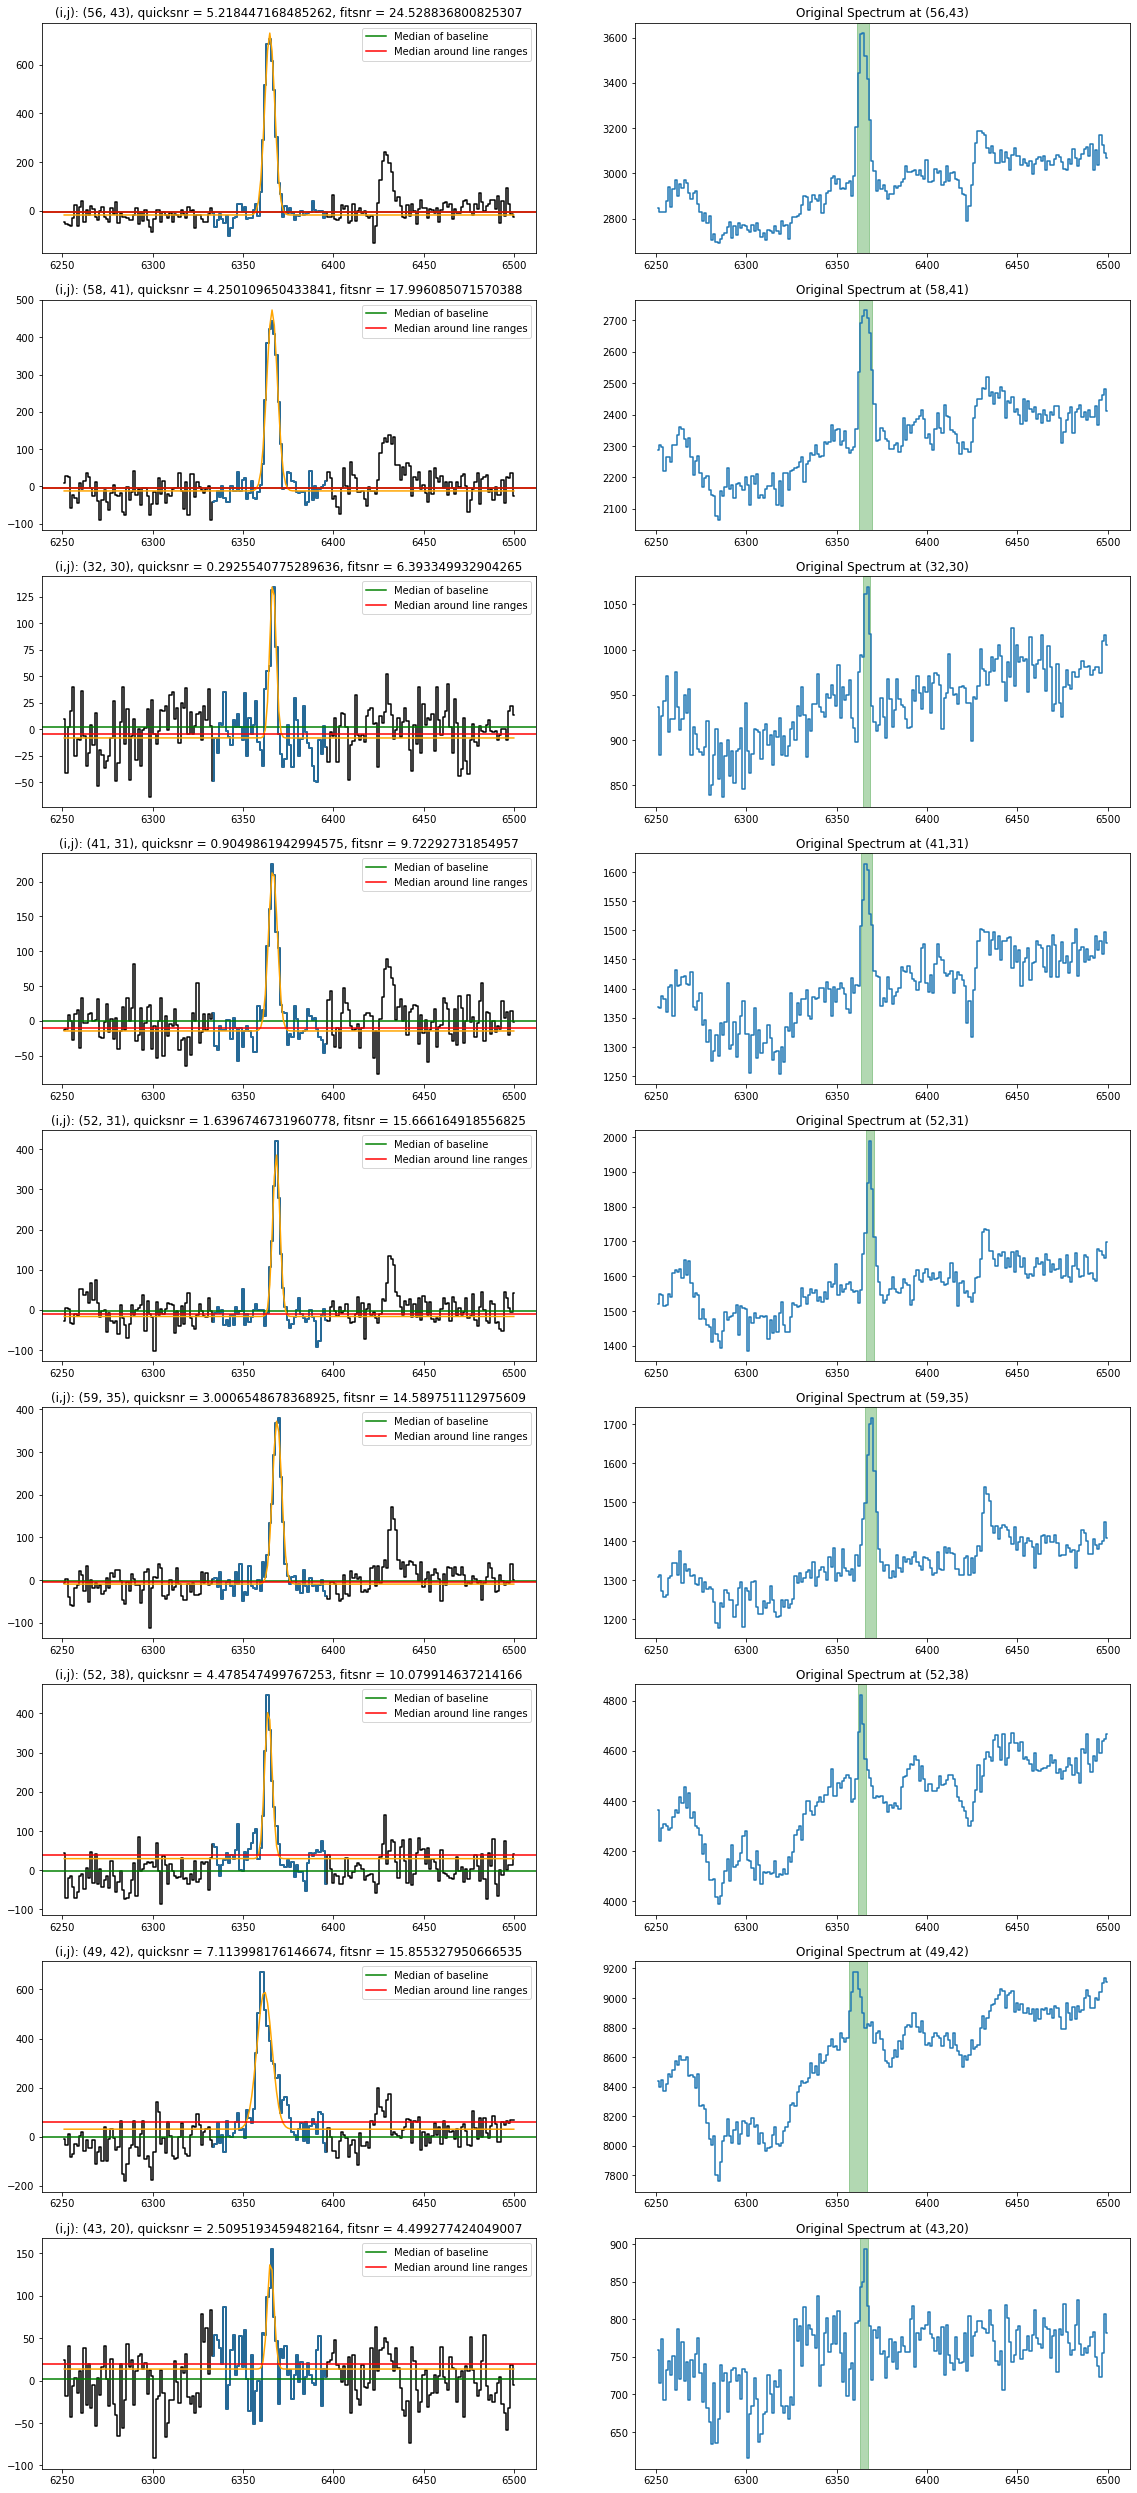

In [5]:

LOW_CONT = [(56,43), (58,41), (32,30), (41,31), (52,31), (59,35)]
HIGH_CONT = [(52,38), (49,42), (43,20)]
oi.plot_eval(LOW_CONT+HIGH_CONT, save=True, fname='OI_cont_single_extreme_cont')

In [3]:
oi.load_fitcubes("../OI_fit/oi_fit_test.fits")
oi.fitcube.shape

(6, 65, 92)

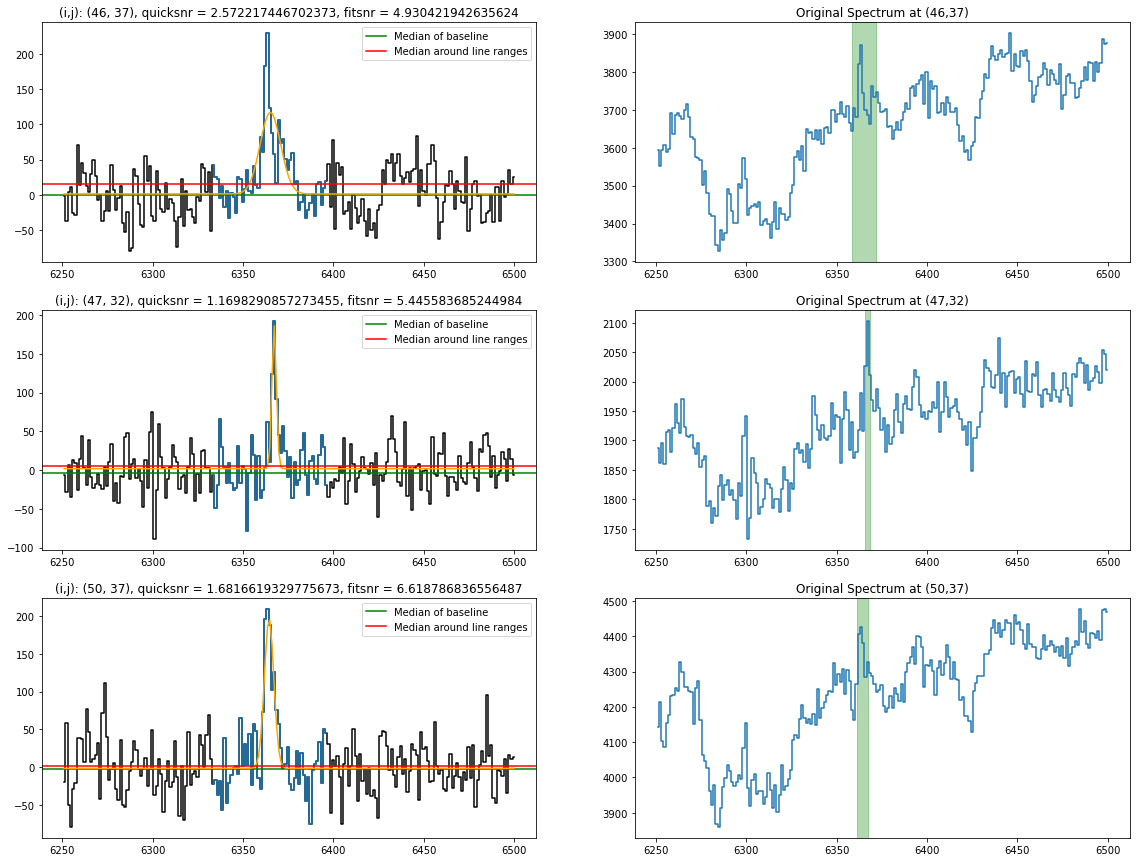

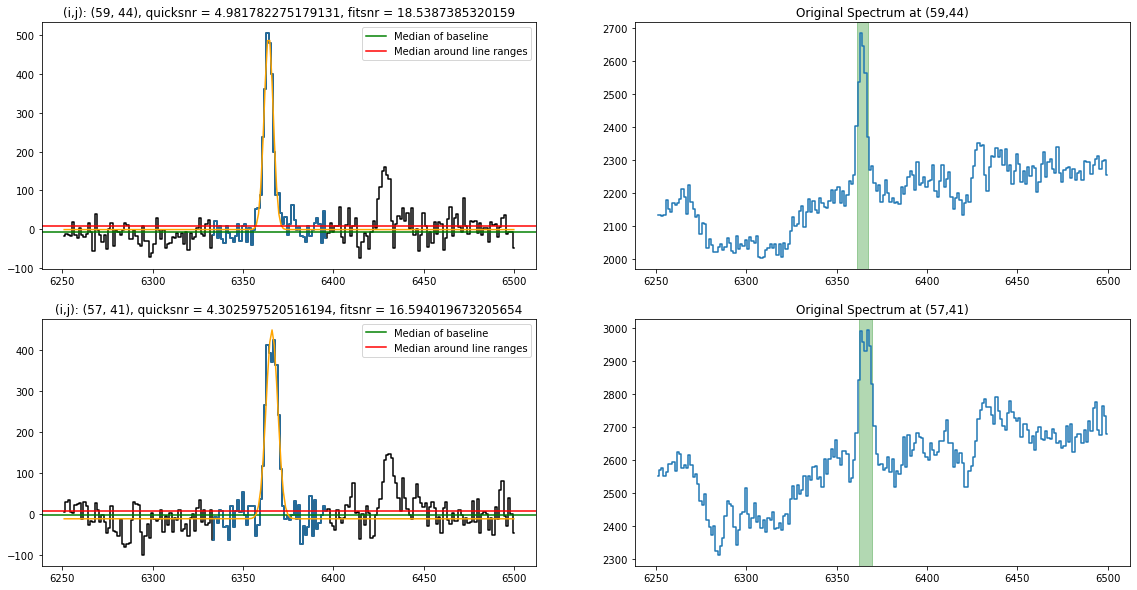

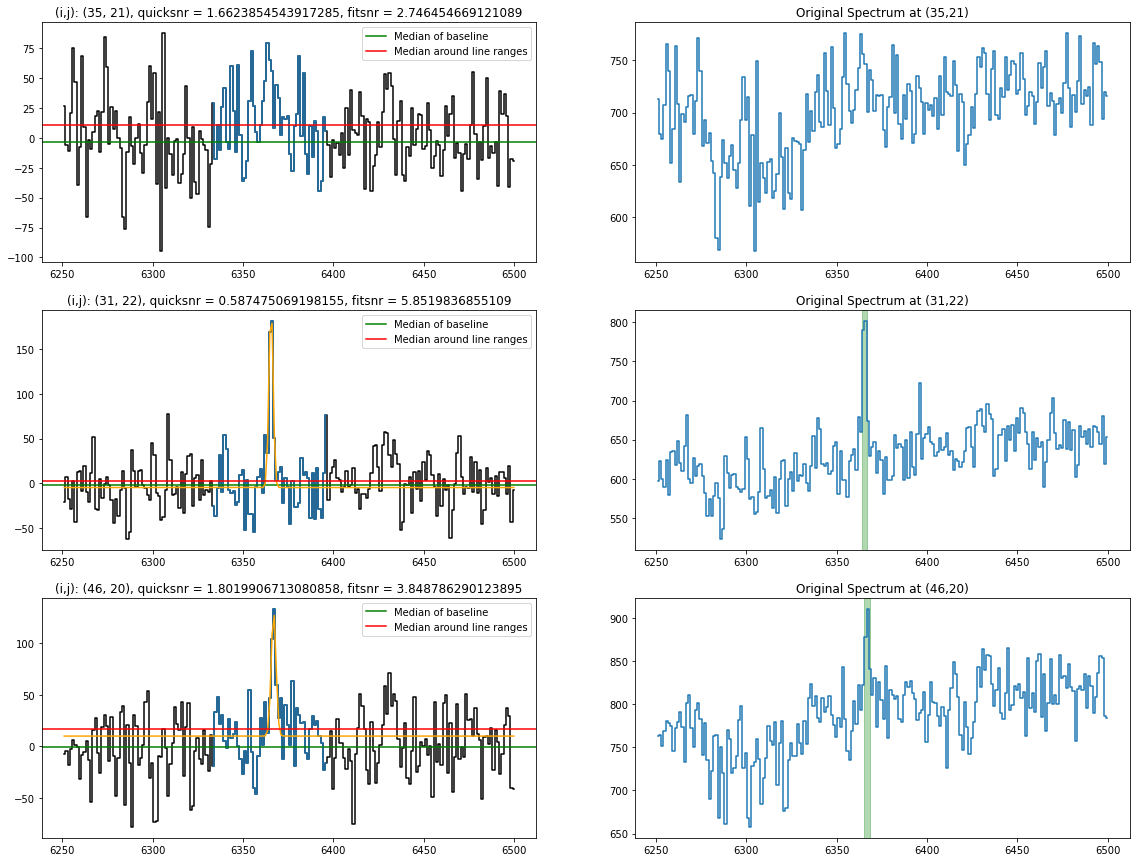

In [8]:
HOLE_PIXELS = [(46,37), (47,32), (50,37)]
GOODPIXELS = [(59,44), (57,41)]
FILAMENTS = [(35,21), (31,22), (46,20)]

oi.plot_eval(HOLE_PIXELS, save=True, fname="OI_hole_cont_")
oi.plot_eval(GOODPIXELS, save=True, fname="OI_good_cont_")
oi.plot_eval(FILAMENTS, save=True, fname="OI_filaments_cont_")